# Volume Rendering Test
Try rendering synthesized AIA emission as a volume with yt. Do this first with one of the datasets we've already produced to see if it is even possible. 

In [28]:
import numpy as np
from scipy.ndimage.filters import gaussian_filter
import astropy.units as u
import sunpy.cm
import matplotlib.pyplot as plt
import yt
import h5py
import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

First, load the base field to get the bounding box information. This will help us construct our yt dataset.

In [2]:
base_field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/base_noaa1158/')

No HMI fits file supplied. A new HMI map object will not be created.
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:190: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:191: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:198: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self

Now, create an AIA instrument. This will help set the grid for our histogram.

In [3]:
aia = InstrumentSDOAIA([0,1]*u.s)
aia.counts_file = '/storage-home/w/wtb2/data/noaa1158_intermediate_frequency/SDO_AIA_counts.h5'
aia.make_detector_array(base_field)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/instruments/base.py:117: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  delta_x = np.fabs(field.clipped_hmi_map.xrange[1] - field.clipped_hmi_map.xrange[0])
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/instruments/base.py:118: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  delta_y = np.fabs(field.clipped_hmi_map.yrange[1] - field.clipped_hmi_map.yrange[0])
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/instruments/base.py:127: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.bin_range = Pair(field._convert_angle_to_length(field.clipped_hmi_map.xrange).value,
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/s

Next, load the data that we'll need. To start off, we'll just take one slice for a single AIA channel.

In [137]:
channel_index = 2

In [193]:
with h5py.File('/storage-home/w/wtb2/data/noaa1158_low_frequency/SDO_AIA_counts.h5','r') as hf:
    unbinned_intensity = np.array(hf[aia.channels[channel_index]['name']][1500,:])
    unbinned_intensity_units = u.Unit(hf[aia.channels[channel_index]['name']].attrs['units'])

Then, create the 3D histogram of the emission and fold it through the PSF. This time we'll use a 3D PSF.

In [194]:
min_z = base_field.extrapolated_3d_field.domain_left_edge[2]*u.cm
max_z = np.max(aia.total_coordinates[:,2])*1.1 # safety factor
bins_z = int(np.ceil((max_z - min_z)/base_field._convert_angle_to_length(aia.resolution.x*(1.*u.pixel))))

In [195]:
intensity,_ = np.histogramdd(
    aia.total_coordinates.value,
    bins=[aia.bins.x,aia.bins.y,bins_z],
    range=[aia.bin_range.x,aia.bin_range.y,[min_z.value,max_z.value]],
    weights=unbinned_intensity
)

In [200]:
intensity_smooth = gaussian_filter(intensity,(2,#aia.channels[channel_index]['gaussian_width']['y'].value,
                                              2,#aia.channels[channel_index]['gaussian_width']['x'].value,
                                              2,#aia.channels[channel_index]['gaussian_width']['x'].value
                                             )
                                  )

Now comes the more complicated step. We need to load our data into a yt dataset so that we can easily visualize it.

In [201]:
tmp = base_field._map_3d[2:-2,2:-2,2:-2, :]
data_dict = dict(
    intensity=(intensity_smooth,''),
    #Bx=(np.swapaxes(tmp[:, :, :, 1], 0, 1), 'T'),
    #By=(np.swapaxes(tmp[:, :, :, 0], 0, 1), 'T'),
    #Bz=(np.swapaxes(tmp[:, :, :, 2], 0, 1), 'T')
)
bbox = np.array([[left,right] for left,right in zip(base_field.extrapolated_3d_field.domain_left_edge.value,
                                                    base_field.extrapolated_3d_field.domain_right_edge.value)])
bbox[2,1] = max_z.value
intensity_ds = yt.load_uniform_grid(data_dict,
                                    intensity_smooth.shape,
                                    bbox=bbox,
                                    length_unit=yt.units.cm,
                                    geometry=('cartesian',('x','y','z')))

yt : [INFO     ] 2017-10-28 20:22:57,270 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-10-28 20:22:57,271 Parameters: domain_dimensions         = [420 440 191]
yt : [INFO     ] 2017-10-28 20:22:57,272 Parameters: domain_left_edge          = [ -2.97931201e+10  -2.62091384e+10   3.91869796e+08]
yt : [INFO     ] 2017-10-28 20:22:57,273 Parameters: domain_right_edge         = [ -1.18463315e+10  -7.41270210e+09   8.55877624e+09]
yt : [INFO     ] 2017-10-28 20:22:57,274 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2017-10-28 20:23:01,833 Projection completed
yt : [INFO     ] 2017-10-28 20:23:01,835 xlim = 391869796.185928 8558776240.084795
yt : [INFO     ] 2017-10-28 20:23:01,835 ylim = -29793120078.254406 -11846331526.051441
yt : [INFO     ] 2017-10-28 20:23:01,837 xlim = 391869796.185928 8558776240.084795
yt : [INFO     ] 2017-10-28 20:23:01,837 ylim = -29793120078.254406 -11846331526.051441
yt : [INFO     ] 2017-10-28 20:23:01,839 Making a fixed resolution buffer of (('stream', 'intensity')) 800 by 800



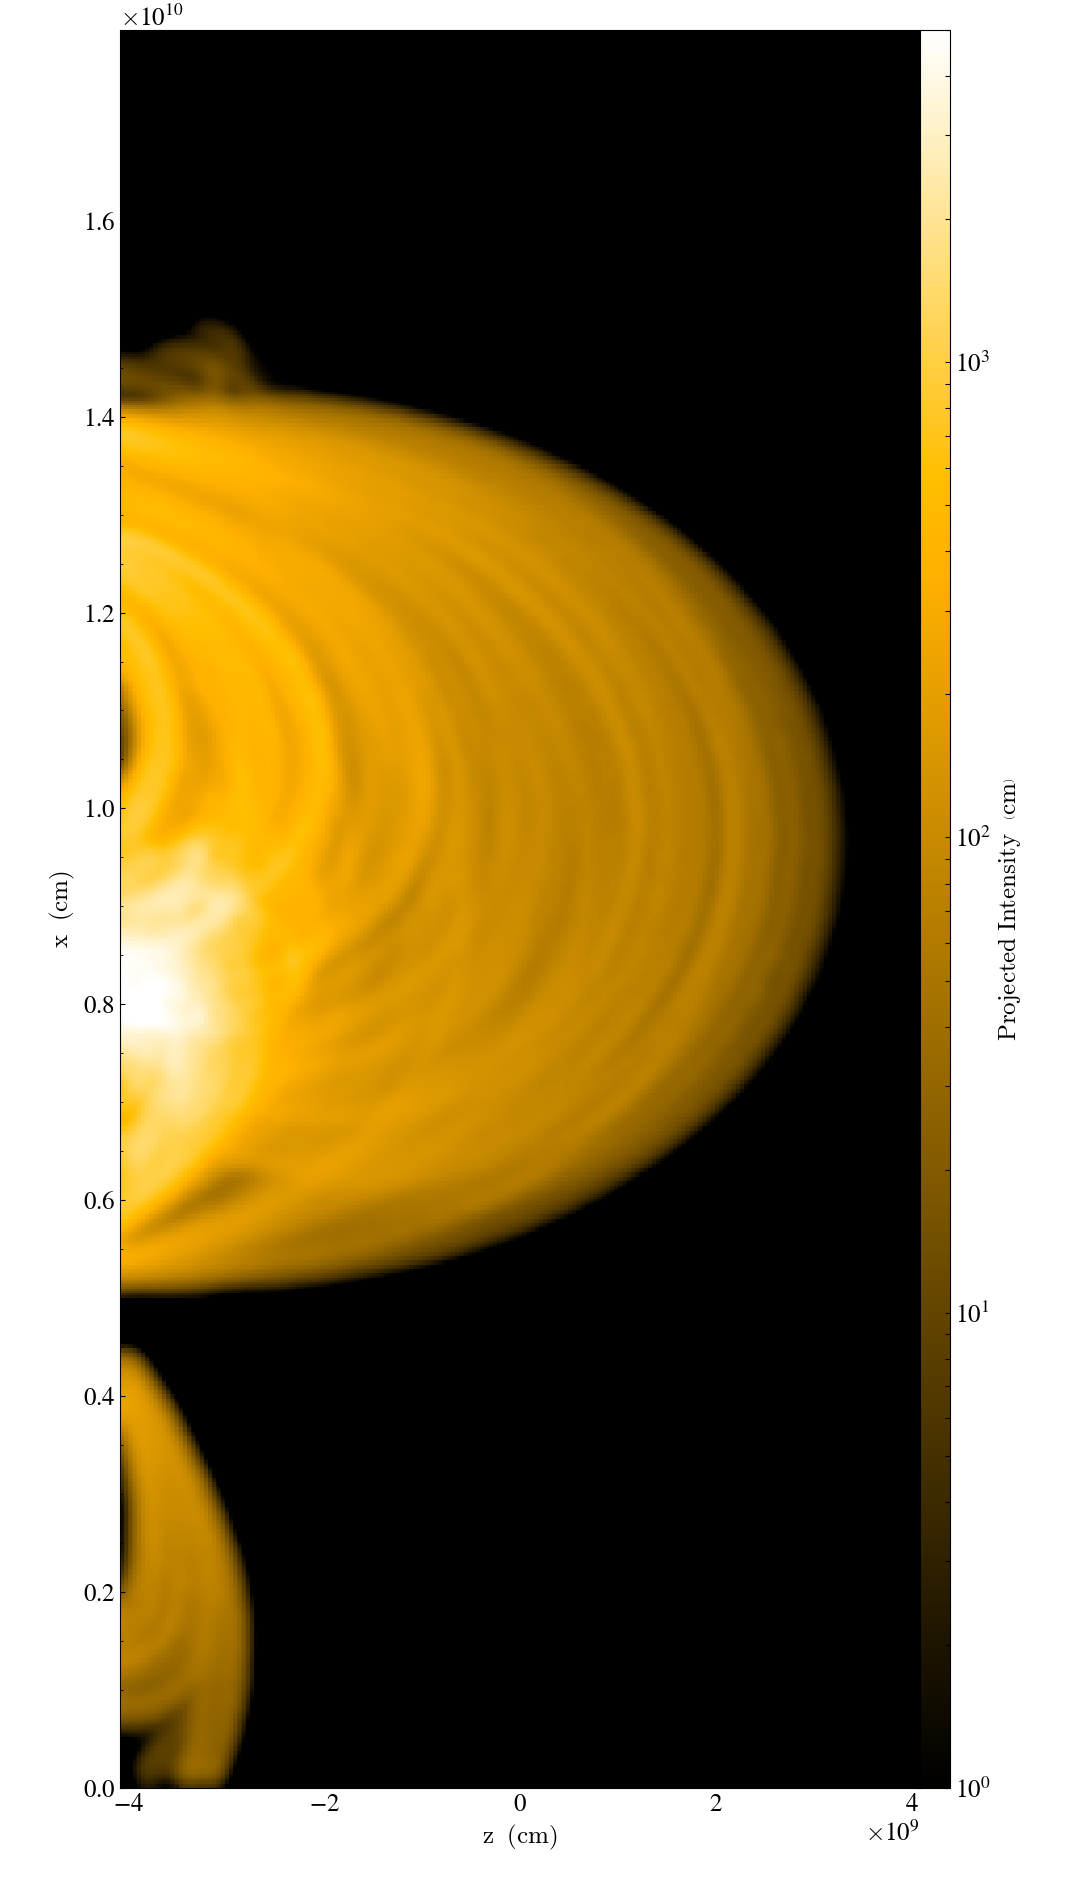

In [202]:
p = yt.ProjectionPlot(intensity_ds,'y','intensity',origin='lower-center-domain',axes_unit='cm')
custom_map = sunpy.cm.get_cmap('sdoaia{}'.format(aia.channels[channel_index]['name']))
custom_map.set_bad()
p.set_cmap('intensity',custom_map)
p.set_zlim('intensity',1e0,5e3,)
p.show()

yt : [INFO     ] 2017-10-28 20:23:08,533 xlim = -8973394276.101482 8973394276.101482
yt : [INFO     ] 2017-10-28 20:23:08,534 ylim = -9398218166.862762 9398218166.862762
yt : [INFO     ] 2017-10-28 20:23:08,535 zlim = -9398218166.862762 9398218166.862762
yt : [INFO     ] 2017-10-28 20:23:08,536 Making a fixed resolution buffer of (('stream', 'intensity')) 800 by 800



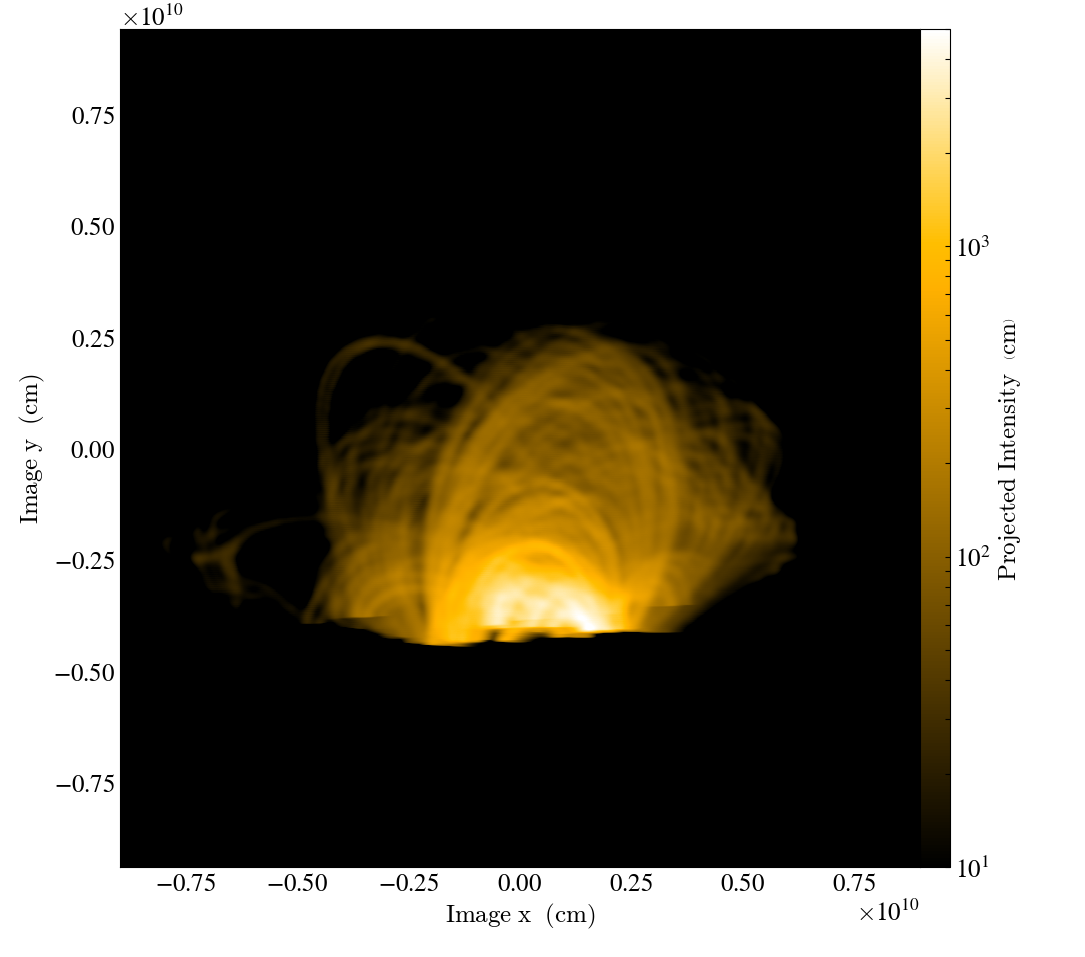

In [203]:
L = [1,1,0.1]
N = [0,0,1]
p = yt.OffAxisProjectionPlot(intensity_ds,L,'intensity',
                             #origin='lower-center-domain',
                             width=intensity_ds.domain_width,
                             north_vector=N,
                             axes_unit='cm',interpolated=False,)
custom_map = sunpy.cm.get_cmap('sdoaia{}'.format(aia.channels[channel_index]['name']))
custom_map.set_bad()
p.set_cmap('intensity',custom_map)
p.set_zlim('intensity',1e1,5e3,)
p.show()

In [146]:
sc = yt.create_scene(intensity_ds,field='intensity')

yt : [INFO     ] 2017-10-28 03:15:13,238 Rendering scene (Can take a while).
yt : [INFO     ] 2017-10-28 03:15:13,240 Creating volume
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/yt/utilities/amr_kdtree/amr_kdtree.py:311: RuntimeWarning: divide by zero encountered in log10
  dds.append(np.log10(vcd[field].astype('float64')))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/yt/utilities/amr_kdtree/amr_kdtree.py:311: RuntimeWarning: invalid value encountered in log10
  dds.append(np.log10(vcd[field].astype('float64')))
yt : [INFO     ] 2017-10-28 03:15:15,258 Creating transfer function
yt : [INFO     ] 2017-10-28 03:15:15,259 Calculating data bounds. This may take a while.  Set the TranferFunctionHelper.bounds to avoid this.


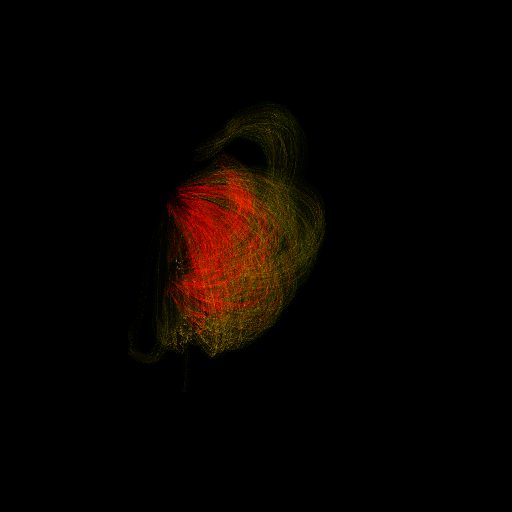

In [147]:
sc.show()